<a href="https://colab.research.google.com/github/Jackson00Han/Time-Series-Training/blob/main/univariate%20time%20series%20without%20exgeneous/Monthly_International_Airline_Passengers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. CNN_RNN_DNN**

## Set Up

In [1]:
import csv
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

## Pre-processing Data

In [2]:
passengers = 'monthly-airline-passengers.csv'
df = pd.read_csv(passengers)
df.set_index('Month', inplace=True)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

period_index = df.index.to_period('M')
diffs = period_index.to_series().astype(int).diff().dropna()

# Calculate time differences

irregularities = diffs[diffs != 1]
if irregularities.empty:
    print("No irregularities found.")
else:
    print("Irregularities found at:")
    print(irregularities)

df.head()

No irregularities found.


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


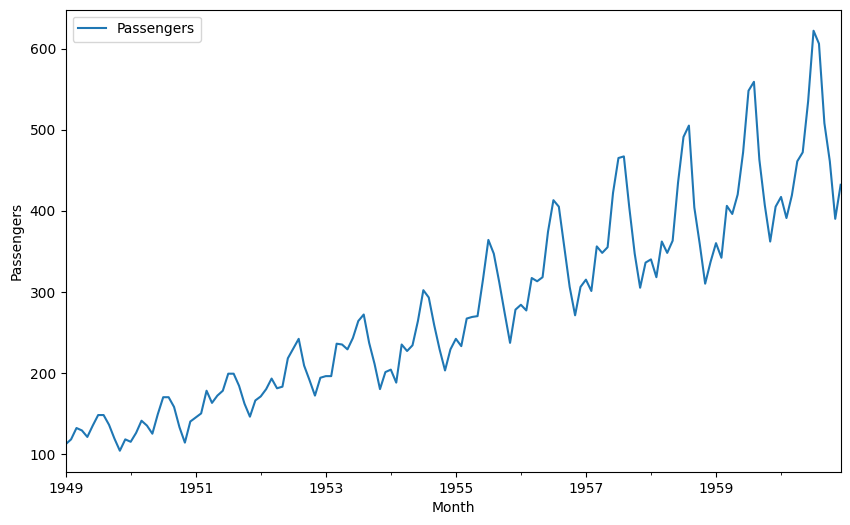

In [4]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
df.plot(ax=ax)
ax.set_ylabel('Passengers')
plt.show()

In [5]:
class G:
    SERIES = df.values
    SPLIT_TIME = 12*11 # Since the seasonality period is 12, we choose 12*10 as the split time here
    WINDOW_SIZE = 12*4 # Since the seasonality period is 12, we choose 12*4 as the window size here
    BATCH_SIZE = 32
    FORECAST_SIZE = 12

    SHUFFLE_BUFFER_SIZE = 200

## Feature Engineering

In [7]:
def train_val_split(series, split_time):
    series_train = series[:split_time]
    series_val = series[split_time:]
    return series_train, series_val

series_train, series_val = train_val_split(G.SERIES, G.SPLIT_TIME)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

train_set = windowed_dataset(series = series_train,
                             window_size = G.WINDOW_SIZE,
                             batch_size = G.BATCH_SIZE,
                             shuffle_buffer = G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture

In [15]:
def lambda_function(x):
    return x * 650
def create_uncompiled_model():

    # Reset states generated by Keras
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                               strides=1, padding="causal",
                               input_shape=[None, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda_function)
    ])

    return model

def adjust_learning_rate(dataset):

  model = create_uncompiled_model()

  lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10 ** (epoch / 30))

  optimizer = tf.keras.optimizers.Adam()
  model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

  history = model.fit(dataset, epochs = 150, callbacks = [lr_schedule])

  return history
lr_history = adjust_learning_rate(train_set)

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 431.4614 - mae: 431.9614 - learning_rate: 1.0000e-05
Epoch 2/150
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 405.5301 - mae: 406.0301

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 411.3345 - mae: 411.8345 - learning_rate: 1.0798e-05
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 392.3059 - mae: 392.8059 - learning_rate: 1.1659e-05
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 360.6674 - mae: 361.1674 - learning_rate: 1.2589e-05
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 337.0285 - mae: 337.5285 - learning_rate: 1.3594e-05
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 322.9329 - mae: 323.4329 - learning_rate: 1.4678e-05
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 311.3724 - mae: 311.8724 - learning_rate: 1.5849e-05
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 291.9575 - mae: 292.4575 - learning_rate: 1.7113e-05
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 270.8035 - mae: 271.3035 - learning_rate: 1.8478e-05
Epoch 10/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 263.6846 - mae: 264.1846 - learning_rate: 1.9953e-05
Epoch 11/150

(1e-05, 1.0, 0.0, 300.0)

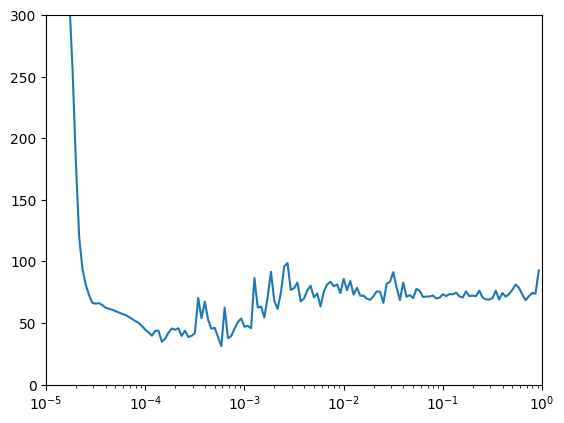

In [11]:
plt.semilogx(lr_history.history['learning_rate'], lr_history.history['loss'])
plt.axis([1e-5, 1 , 0, 300])

It turns out that the model performs more stable and better when the learning rate is around 1e-4.

## Compiling the model

In [12]:
def create_model():

  model = create_uncompiled_model()

  model.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['mae'])

  return model

model = create_model()

history = model.fit(train_set, epochs=100) # We can also add a validation set here to monitor the training process

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 165.1906 - mae: 165.6906
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 75.6876 - mae: 76.1876
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 74.1785 - mae: 74.6785
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 66.6439 - mae: 67.1439
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 67.7526 - mae: 68.2483
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 58.6093 - mae: 59.1052
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 53.4790 - mae: 53.9762
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 47.9069 - mae: 48.4028
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 53.7011 - mae: 54.2009
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 44.6468 - mae: 45.1468
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 40.5502 - mae: 41.0501
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 34.9837 - mae: 35.4766
Epoch 13/100
3/3 ━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
mse: 5171.79711709901
mae: 58.17527770996094


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


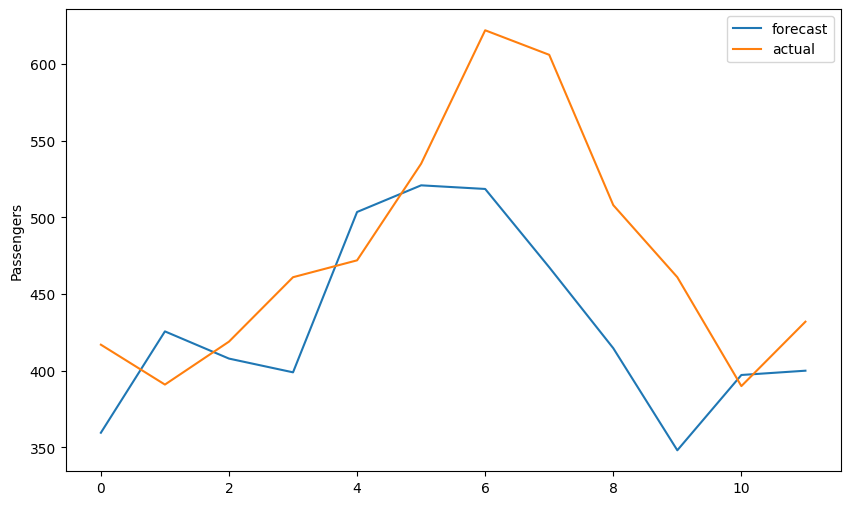

In [14]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(G.BATCH_SIZE).prefetch(1)
    forecast = model.predict(ds)

    return forecast

num = len(series_val)

lstm_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze() # Compute the forecast for all series
lstm_forecast = lstm_forecast[-num:] # slice the forecast to get only the prediction for the validation set


from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(series_val, lstm_forecast)
mae = mean_absolute_error(series_val, lstm_forecast)

print(f'mse: {mse}')
print(f'mae: {mae}')


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lstm_forecast, label='forecast')
ax.plot(series_val, label='actual')
ax.set_ylabel('Passengers')
ax.legend()
plt.show()

mse: 0.0026148069598132782
mae: 0.03902472742978113


## Deploy Model and Forecast

In [71]:
last_rows = df_log_diff[-48:]


In [74]:
# If we want to forecast next multi-steps, we can use the following autoregressive forecasting algorithm

def forecast_single_rolling_window(test_window, model, window_size, forecast_size):

    buffer = test_window.values
    forecast_list = np.zeros(forecast_size)

    for i in range(forecast_size):
        input = buffer.reshape(1, window_size, 1)
        forecast = model.predict(input)[0][0]
        forecast_list[i] = forecast

        buffer[1:] = buffer[:-1]
        buffer[0] = forecast

    return forecast_list

forecasts = forecast_single_rolling_window(last_rows, model, G.WINDOW_SIZE, G.FORECAST_SIZE)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


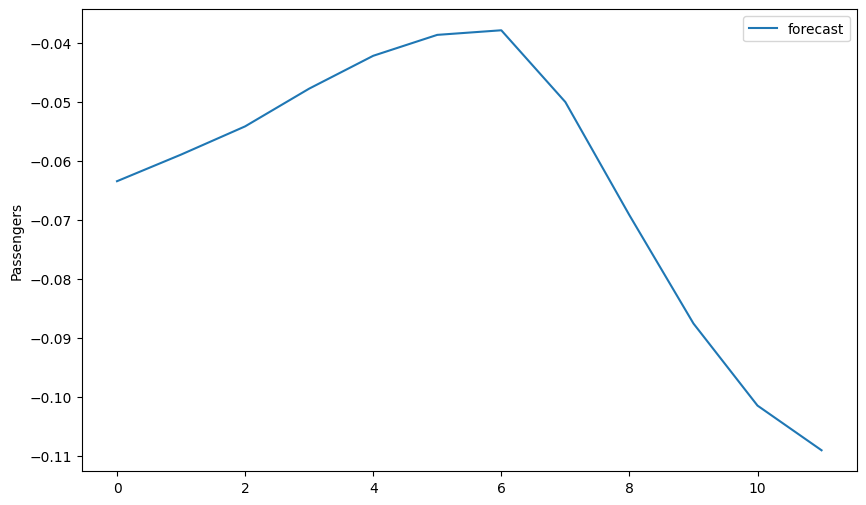

In [76]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(forecasts, label='forecast')
ax.set_ylabel('Passengers')
ax.legend()
plt.show()

# **2.PyCaret**

## Preparation

PyCaret is an open-source, low-code machine learning library in Python that automates machine learning workflows. With PyCaret, you spend less time coding and more time on analysis. You can train your model, analyze it, iterate faster than ever before, and deploy it instantaneously as a REST API or even build a simple front-end ML app, all from your favorite Notebook.

In [ ]:
pip install pycaret[full]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 45.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of selenium to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of selenium t

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.datasets import get_data
#from pycaret.time_series import TSForecastingExperiment
from pycaret.time_series import *

#from dataclasses import dataclass

In [ ]:
data = get_data('monthly-airline-passengers', verbose=False)

data['Month'] = pd.to_datetime(data['Month'])

data.set_index('Month', inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [ ]:
data

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


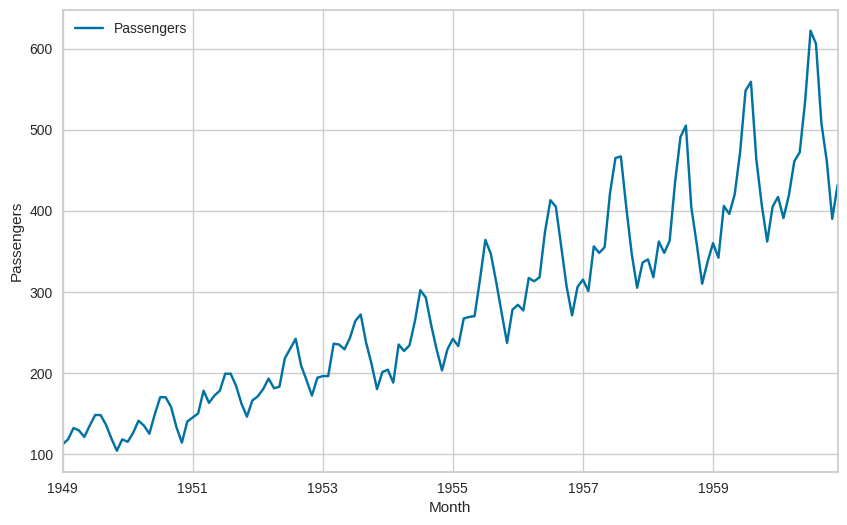

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
data.plot(ax=ax)
ax.set_ylabel('Passengers')
plt.show()

In [ ]:
fh=12

# Global Figure Settings for notebook ----
# Depending on whether you are using jupyter notebook, jupyter lab, Google Colab, you may have to set the renderer appropriately
# NOTE: Setting to a static renderer here so that the notebook saved size is reduced.
fig_kwargs = {
    # "renderer": "notebook",
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

## EDA (not necessary)

In [ ]:
eda = TSForecastingExperiment()
eda.setup(data, target='Passengers', fh = fh, fold=3, session_id=31, fig_kwargs=fig_kwargs)

,Description,Value
0,session_id,31
1,Target,Passengers
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(144, 1)"
5,Transformed data shape,"(144, 1)"
6,Transformed train set shape,"(132, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


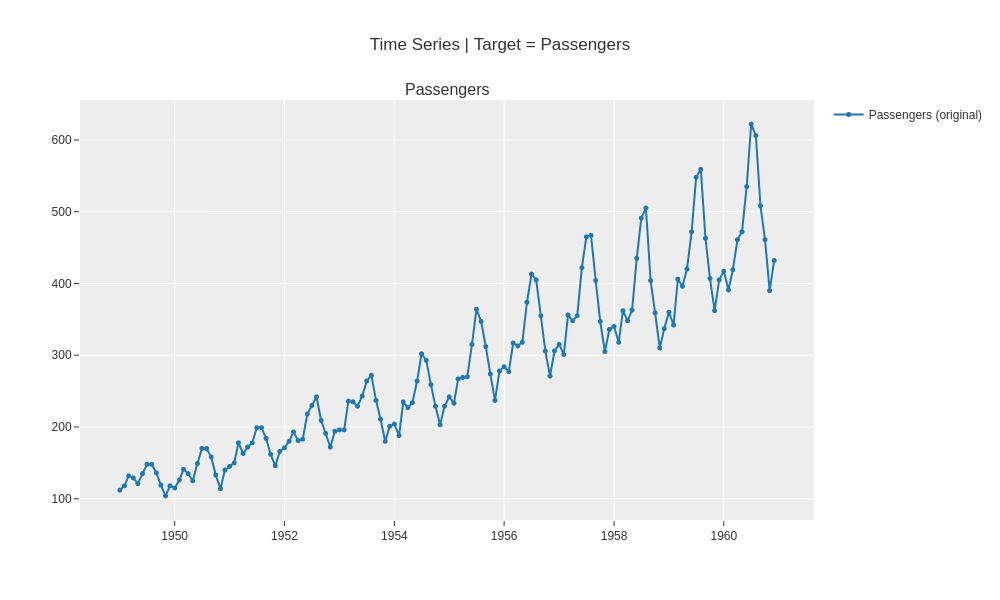

In [ ]:
# NOTE: This is the same as `eda.plot_model(plot="ts")`
eda.plot_model()

 For now, our data does not have any missing values or any transformations. So **Data Input (by user), i.e. Original data = Imputed data = Transformed data = Data fed to models**. We can verify this by plotting the internal datasets by specifying the `plot_data_type` `data_kwargs`.

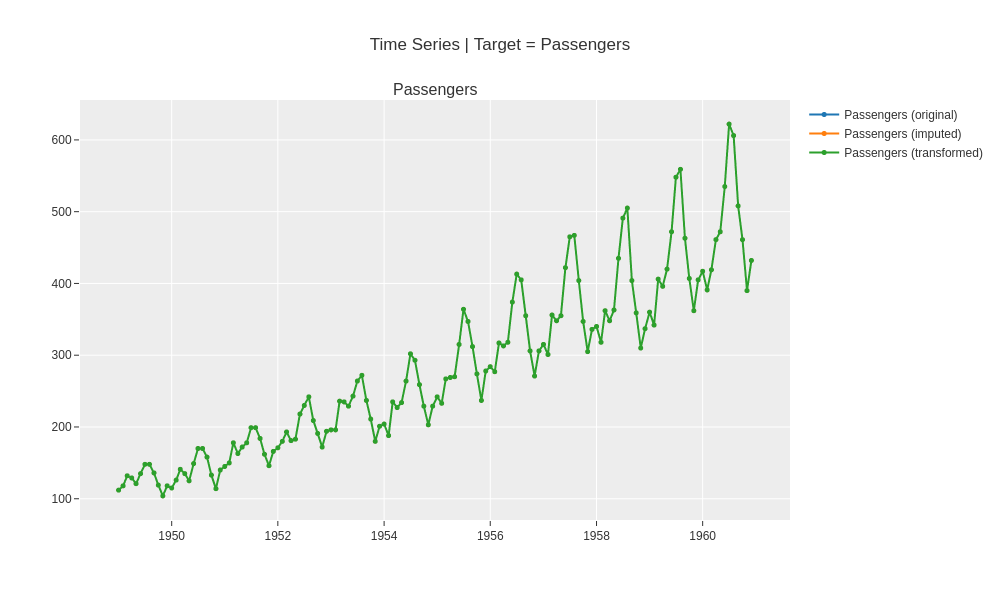

In [ ]:
eda.plot_model(data_kwargs={"plot_data_type": ["original", "imputed", "transformed"]})

In the plots above, we notice

Peaking at f ~= 0 indicating that we need to difference the data.
Peaking at f = 0.0833, 0.1677, 0.25, 0.3333, 0.4167. All these are multiple of 0.0833. Hence 0.0833 is the fundamental frequency and the seasonal period is 1/0.0833 = 12.

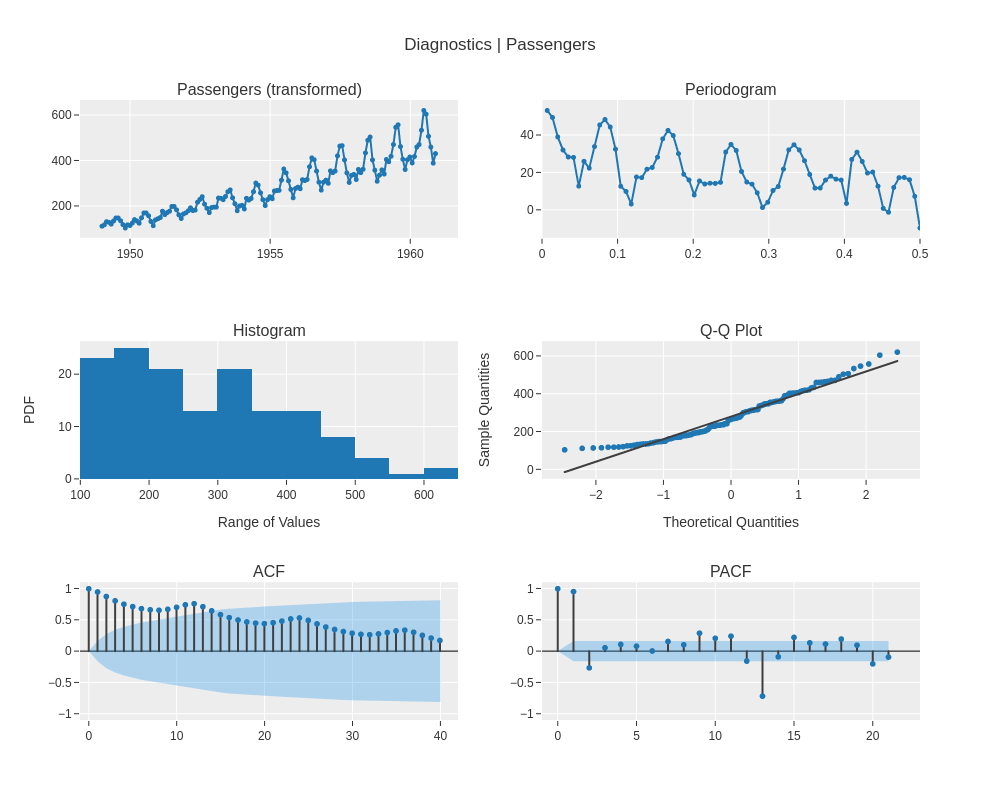

In [ ]:
# Alternately, the diagnostics plot provides all these details in a convenient call.

eda.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})

Our diagnostic plots indicated the need to difference and the presence of a seasonal period of 12. Let's see what happends when we remove this from the model. What other characteristics are left in the model that would need to be taken care of?

This can be achieved through the difference plots. Along with the difference plots, we will plot the corresponding ACF, PACF and Periodogram for further diagnostics.

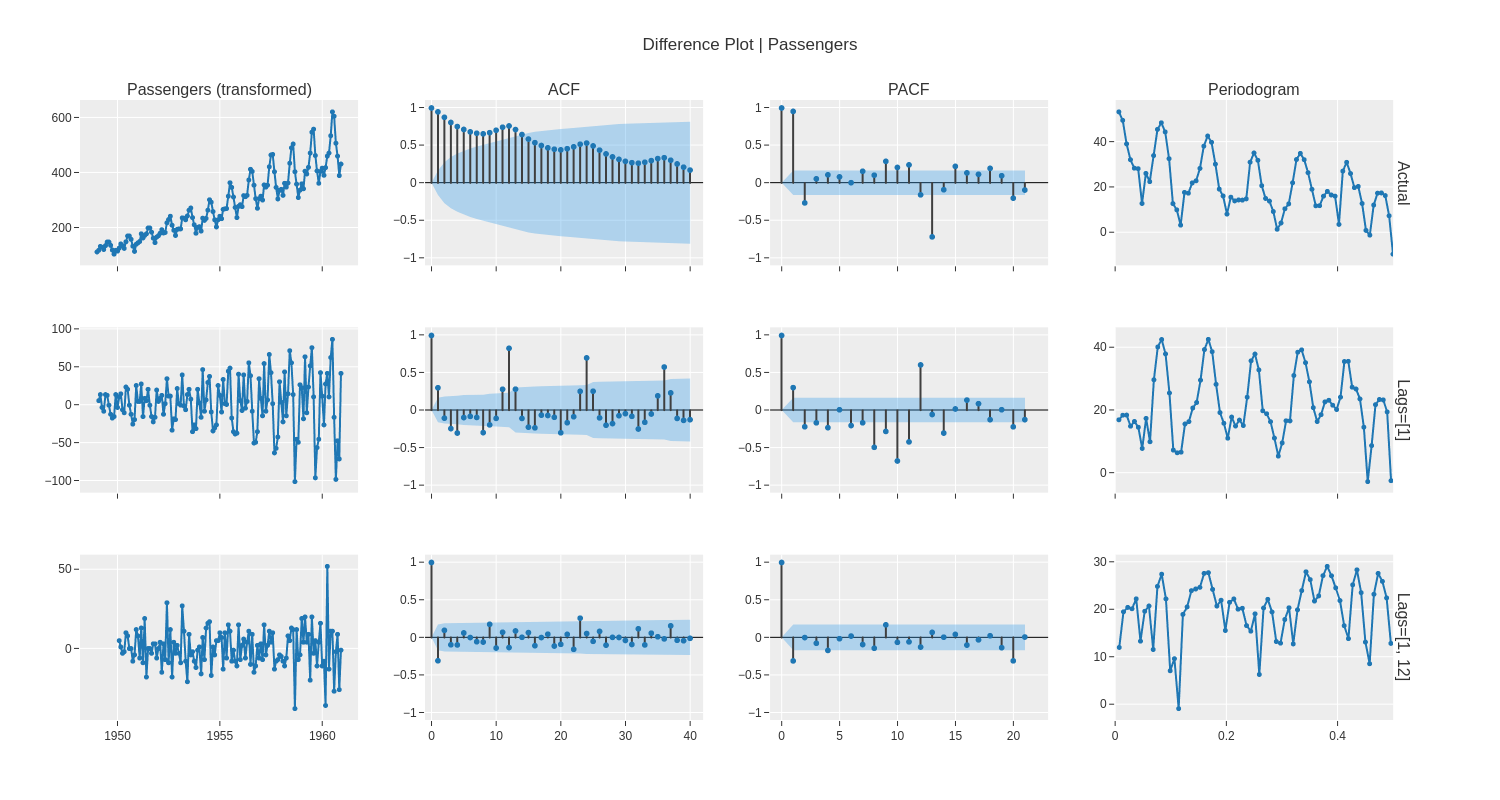

In [ ]:

#   - Corresponds to applying a standard first difference to handle trend, and
#     followed by a seasonal difference (at lag 12) to attempt to account for
#     seasonal dependence.
# Ref: https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.transformations.series.difference.Differencer.html
eda.plot_model(
    plot="diff",
    data_kwargs={"lags_list": [[1], [1, 12]], "acf": True, "pacf": True, "periodogram": True},
    fig_kwargs={"height": 800, "width": 1500}
)
# The output is shown below
# Row 1: Original
# Row 2: d = 1
# Row 3: First (d = 1) then (D = 1, s = 12)




# ## NOTE: Another way to specify differences is using order_list
# # Row 1: Original
# # Row 2: d = 1
# # Row 3: d = 2
# eda.plot_model(
#     plot="diff",
#     data_kwargs={
#         "order_list": [1, 2],
#         "acf": True, "pacf": True, "periodogram": True
#     },
#     fig_kwargs={"height": 600, "width": 1200}
# )

Observations:


In the second row, we have only removed the wandering behavior by taking a first difference. This can be seen in the ACF plot (extended autocorrelations are gone) and Periodogram (peaking at f =~ 0 is squished). The ACF (preaking at seasonal period of 12 and its multiples) and PACF (peaking at fundamental frequency of 0.0833 and its multiples) still show the seasonal behavior.
In the third row, we have taken first difference followed by a seasonal difference of 12. Now, we can see that the peaking at seasonal multiples is gone from both ACF and Periodogram. There is still a little bit of autoregresssive properties that we have not taken care of but by looking at the PACF, maybe p=1 seems like a reasonable value to use (most lags after that are insignificant).
Conclusion

If you were modeling this with ARIMA, the model to try would be ARIMA(1,1,0)x(0,1,0,12).
Other models could use this information appropriately. For example, reduced regression models could remove the trend and seasonality of 12 (i.e. make the data stationary) before modeling the rest of the autoregressive properties. Luckily, the pycaret time series module will take care of this **internally**.

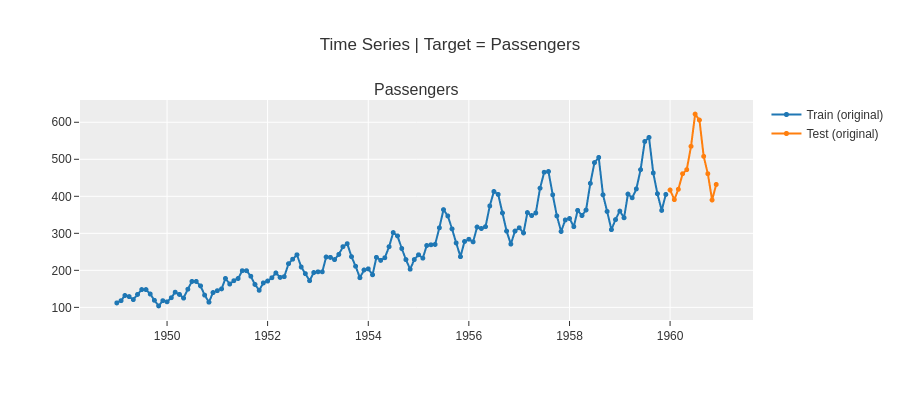

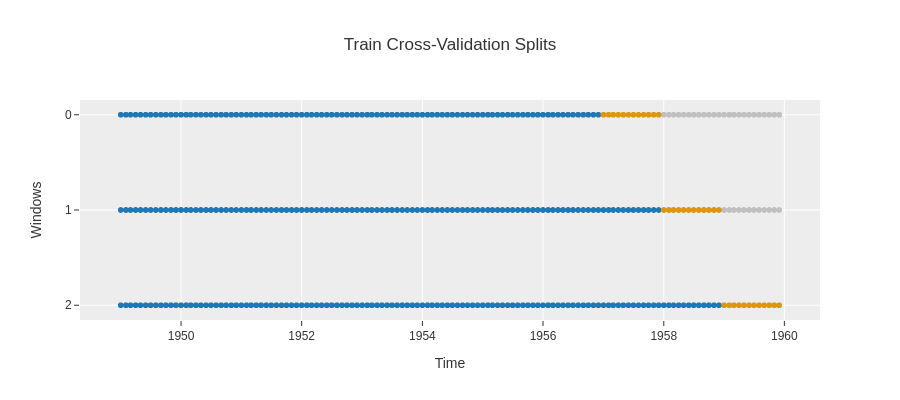

In [ ]:
# Show the train-test splits on the dataset
# Internally split - len(fh) as test set, remaining used as test set
eda.plot_model(plot="train_test_split", fig_kwargs={"height": 400, "width": 900})

# Show the Cross Validation splits inside the train set
# The blue dots represent the training data for each fold.
# The orange dots represent the validation data for each fold
eda.plot_model(plot="cv", fig_kwargs={"height": 400, "width": 900})

## Set Up

In [ ]:
s = setup(data, target='Passengers', fh = fh, fold=3, session_id=31, fig_kwargs=fig_kwargs)

,Description,Value
0,session_id,31
1,Target,Passengers
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(144, 1)"
5,Transformed data shape,"(144, 1)"
6,Transformed train set shape,"(132, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [ ]:
check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,144.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,280.298611
3,Summary,Statistics,Transformed,Median,,265.5
4,Summary,Statistics,Transformed,Standard Deviation,,119.966317
5,Summary,Statistics,Transformed,Variance,,14391.917201
6,Summary,Statistics,Transformed,Kurtosis,,-0.364942
7,Summary,Statistics,Transformed,Skewness,,0.58316
8,Summary,Statistics,Transformed,# Distinct Values,,118.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",1606.083817


## Compare Models

In [ ]:
best = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
exp_smooth,Exponential Smoothing,0.5852,0.6105,17.1926,20.1633,0.0435,0.0439,0.8918,0.1667
ets,ETS,0.5931,0.6212,17.4165,20.5102,0.0440,0.0445,0.8882,0.2400
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.6482,0.7089,19.1419,23.4703,0.0477,0.0475,0.8528,0.9767
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.6813,0.7866,20.0334,25.9670,0.0491,0.0499,0.8113,0.5767
arima,ARIMA,0.6830,0.6735,20.0069,22.2199,0.0501,0.0507,0.8677,0.1833
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.7004,0.7702,20.6084,25.4401,0.0509,0.0514,0.8215,0.9000
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.7004,0.7703,20.6086,25.4405,0.0509,0.0514,0.8215,1.0100
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.7029,0.7732,20.6816,25.5362,0.0511,0.0516,0.8201,1.1000
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.7048,0.7751,20.7373,25.6005,0.0512,0.0517,0.8193,0.5467
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.7048,0.7751,20.7366,25.6009,0.0512,0.0517,0.8192,0.5600


Processing:   0%|          | 0/121 [00:00<?, ?it/s]

## Prediction

In [ ]:
# The predict_model function returns y_pred.
pred = predict_model(best)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,0.3382,0.4575,10.2997,15.8074,0.0221,0.0216,0.9549


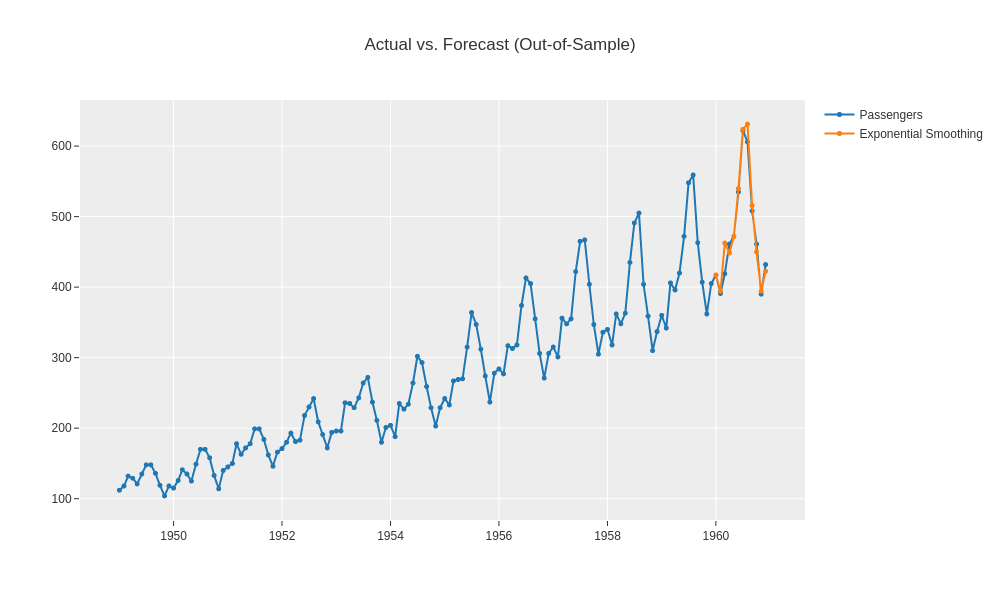

In [ ]:
plot_model(best, plot = 'forecast')

In [ ]:
# If one wants to predict the future 36 months

pred_future = predict_model(best, fh=36)

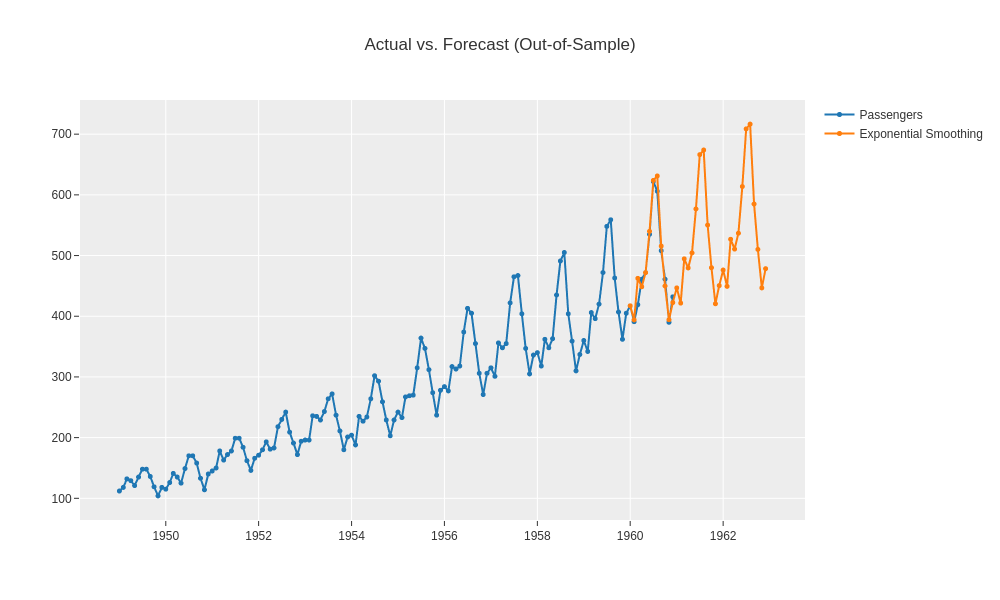

In [ ]:
plot_model(best, plot = 'forecast', data_kwargs = {'fh': 36})

## Save and deploy models

In [ ]:
# Finalize model
final_best = finalize_model(best)

# Save model
save_model(final_best, 'my_final_best_model')

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 ExponentialSmoothing(seasonal='mul',
                                                                                                                                                      sp=12,
                                                                                                                                                      trend='add'))]))]))]))]),
 'my_final_best_model.pkl')

In [ ]:
# To load model back

loaded_model = load_model('my_final_best_model')
print(loaded_model)

Transformation Pipeline and Model Successfully Loaded
ForecastingPipeline(steps=[('forecaster',
                            TransformedTargetForecaster(steps=[('model',
                                                                ForecastingPipeline(steps=[('forecaster',
                                                                                            TransformedTargetForecaster(steps=[('model',
                                                                                                                                ExponentialSmoothing(seasonal='mul',
                                                                                                                                                     sp=12,
                                                                                                                                                     trend='add'))]))]))]))])


In [ ]:
pred_future_pro = predict_model(loaded_model, fh=36)

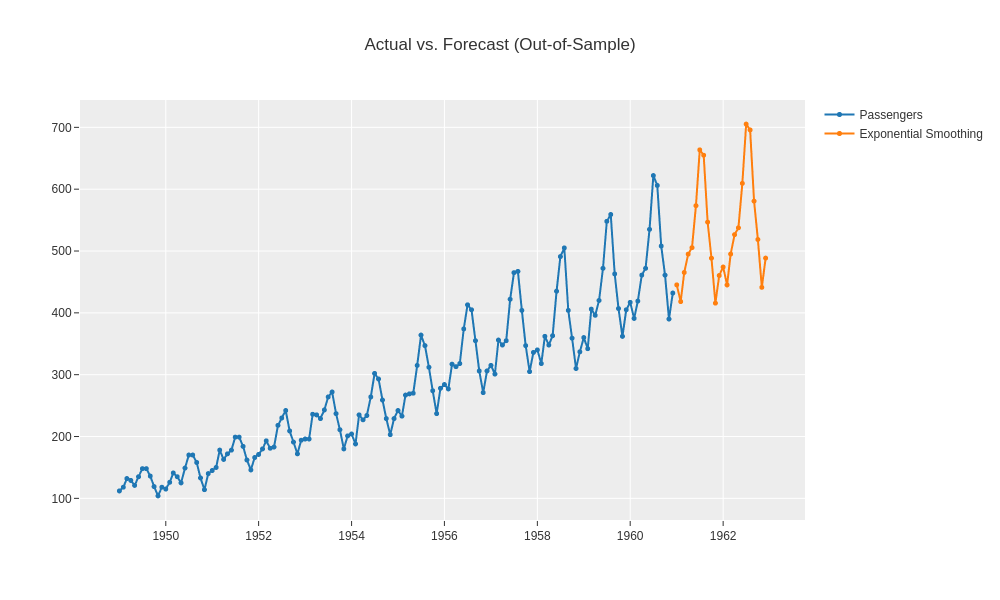

In [ ]:
plot_model(loaded_model, plot = 'forecast', data_kwargs = {'fh': 24})

# **3.SARIMA**

## Set Up

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import joblib

## Pre-processing Data

In [4]:
df = pd.read_csv('monthly-airline-passengers.csv', index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


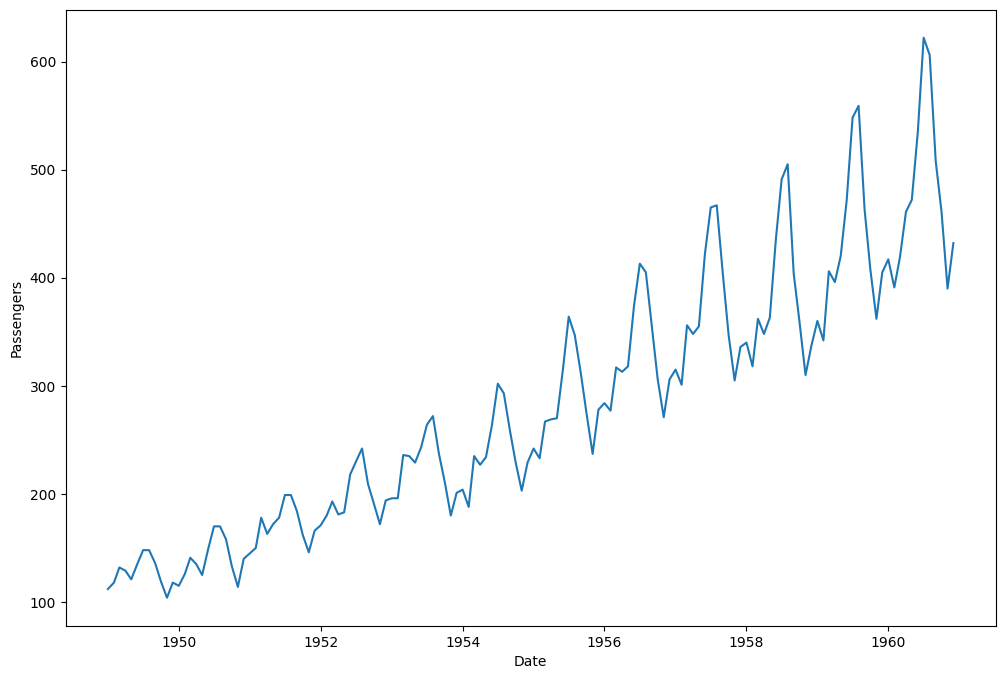

In [8]:
fig, ax= plt.subplots(figsize=(12, 8))
ax.plot(df)
ax.set_ylabel('Passengers')
ax.set_xlabel('Date')
plt.show()

Since the seasonality is multiplicative, we need to take a log transformation before using SARIMA model.

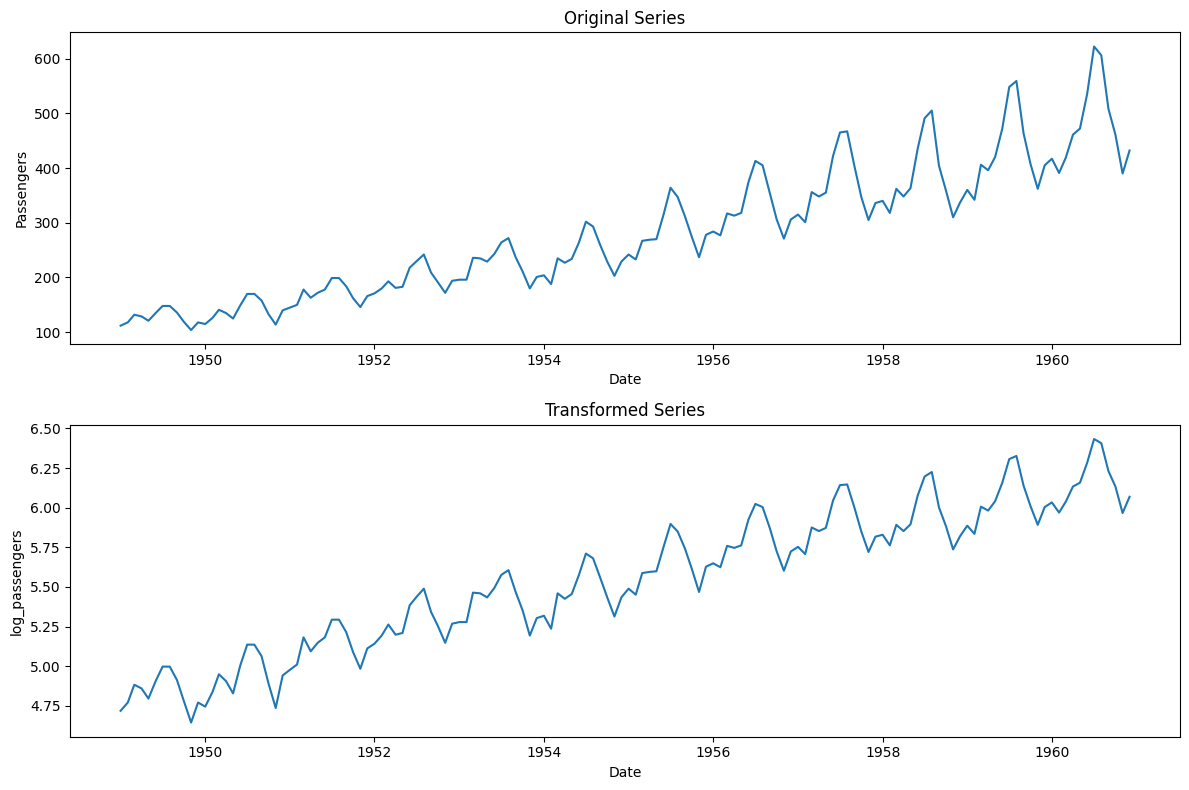

In [15]:
df['log_passengers'] = np.log(df['Passengers'])

df_log = df['log_passengers'].copy()

fig, axs = plt.subplots(2,1, figsize=(12, 8))
axs[0].plot(df['Passengers'])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Passengers')
axs[0].set_title('Original Series')

axs[1].plot(df_log)
axs[1].set_xlabel('Date')
axs[1].set_ylabel('log_passengers')
axs[1].set_title('Transformed Series')

plt.tight_layout()
plt.show()

## Choosing SARIMA Order

### Manually order selecting

1st non-seasonal differencing and 1st seasonal differencing

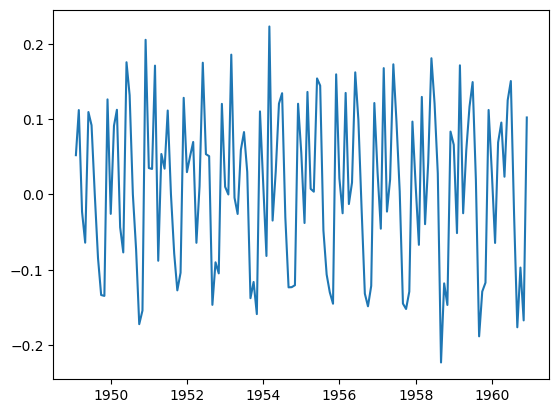

In [27]:
df_log_diff_1 = df_log.diff(1).dropna()

plt.plot(df_log_diff_1)
plt.show()

The curve above has clear seasonality

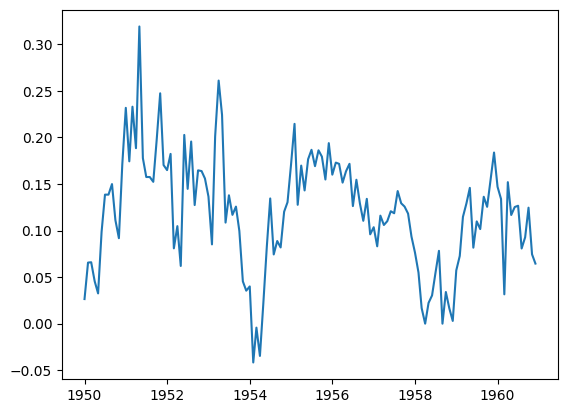

In [28]:
df_log_diff_2 = df_log.diff(12).dropna()

plt.plot(df_log_diff_2)
plt.show()

The curve above has a clear dynamic variance

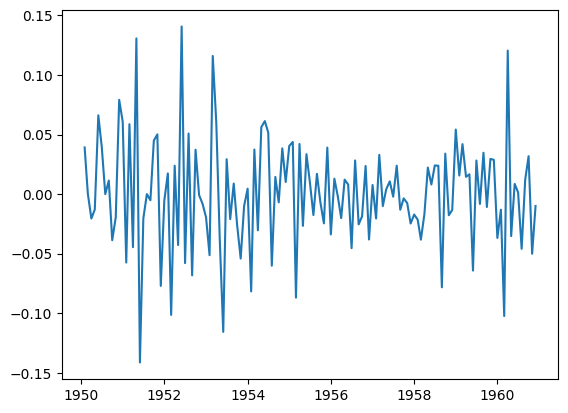

In [29]:
df_log_diff_3 = df_log.diff(1).diff(12).dropna()

plt.plot(df_log_diff_3)
plt.show()

The curve above appears relatively stable. We use this for further training.

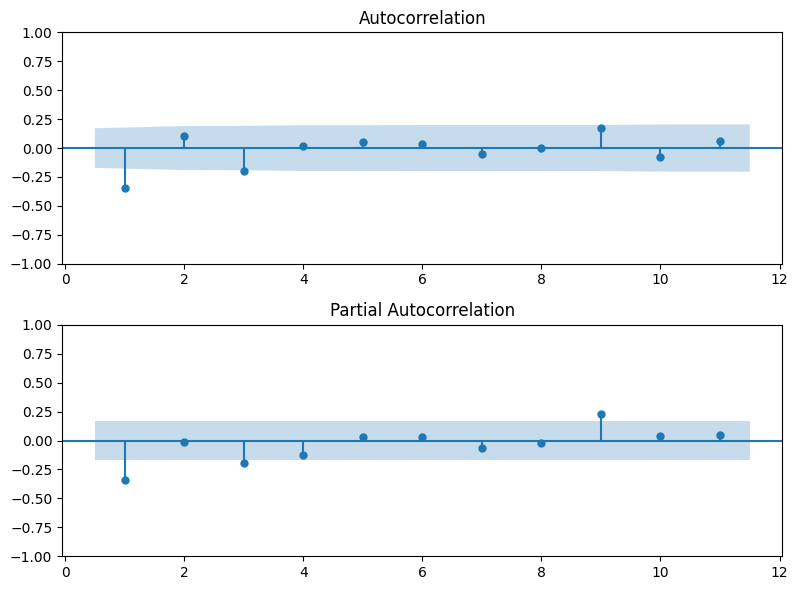

In [32]:
df_log_diff = df_log_diff_3

# ACF and PACF
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 6))

plot_acf(df_log_diff, ax=ax1, zero=False, lags=11)
plot_pacf(df_log_diff, ax=ax2, zero=False, lags=11)

plt.tight_layout()
plt.show()

ACF cuts off at lag 1, PACF cuts off at lag 1 as well with a weeker sign. In face, both figs have no strong signs. One may try (p,q)= (1,1), or (0,1)

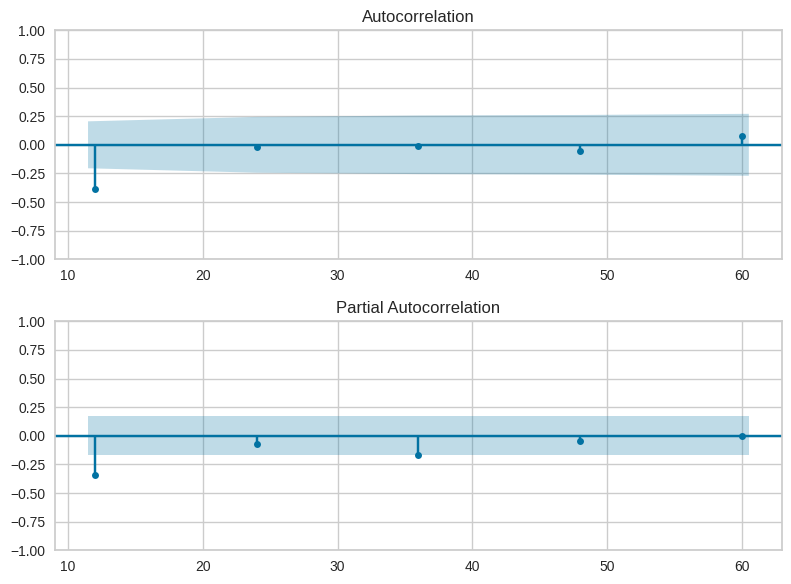

In [ ]:
lags = [12, 24, 36, 48, 60]

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 6))

plot_acf(df_log_diff, ax=ax1, zero=False, lags=lags)
plot_pacf(df_log_diff, ax=ax2, zero=False, lags=lags)

plt.tight_layout()
plt.show()

ACF cuts off at lag 12, PACF cuts off at lag 12 with a weeker sign.One may try (P,Q) = (1,1), or (0,1). Then select one based on AIC or BIC.

Overall, one may try the following orders:

Order (1,1,1) (1,1,1)_12

Order (1,1,1) (0,1,1)_12

Order (0,1,1) (1,1,1)_12

Order (0,1,1) (0,1,1)_12

In [59]:
# Order (1,1,1) (1,1,1)_12
model = SARIMAX(df_log, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_1 = model.fit()
print(results_1.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                     log_passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 245.152
Date:                            Wed, 18 Sep 2024   AIC                           -480.304
Time:                                    13:13:35   BIC                           -465.928
Sample:                                01-01-1949   HQIC                          -474.462
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1665      0.213      0.782      0.434      -0.251       0.584
ma.L1         -0.5611      0.185   

In [60]:
# Order (1,1,1) (0,1,1)_12
model = SARIMAX(df_log, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
results_2 = model.fit()
print(results_2.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                     log_passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.946
Date:                            Wed, 18 Sep 2024   AIC                           -481.893
Time:                                    13:13:43   BIC                           -470.392
Sample:                                01-01-1949   HQIC                          -477.220
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1965      0.199      0.987      0.323      -0.194       0.587
ma.L1         -0.5788      0.171   

In [61]:
# Order (0,1,1) (1,1,1)_12
model = SARIMAX(df_log, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))
results_3 = model.fit()
print(results_3.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                     log_passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 244.953
Date:                            Wed, 18 Sep 2024   AIC                           -481.906
Time:                                    13:13:56   BIC                           -470.405
Sample:                                01-01-1949   HQIC                          -477.233
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4143      0.074     -5.633      0.000      -0.558      -0.270
ar.S.L12      -0.1105      0.185   

In [62]:
# Order (0,1,1) (0,1,1)_12
model = SARIMAX(df_log, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
results_4 = model.fit()
print(results_4.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                     log_passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                            Wed, 18 Sep 2024   AIC                           -483.393
Time:                                    13:13:59   BIC                           -474.767
Sample:                                01-01-1949   HQIC                          -479.888
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4018      0.073     -5.502      0.000      -0.545      -0.259
ma.S.L12      -0.5569      0.096   

In [67]:
# Check out the aic values of these models
for i in range(1, 5):
    aic = eval(f"results_{i}.aic")
    print(aic)

-480.3037233777798
-481.8929842475537
-481.90623625869284
-483.39297335045745


In terms of AIC, it seems like Order (0,1,1) (0,1,1)_12 performs best among these 4 models.



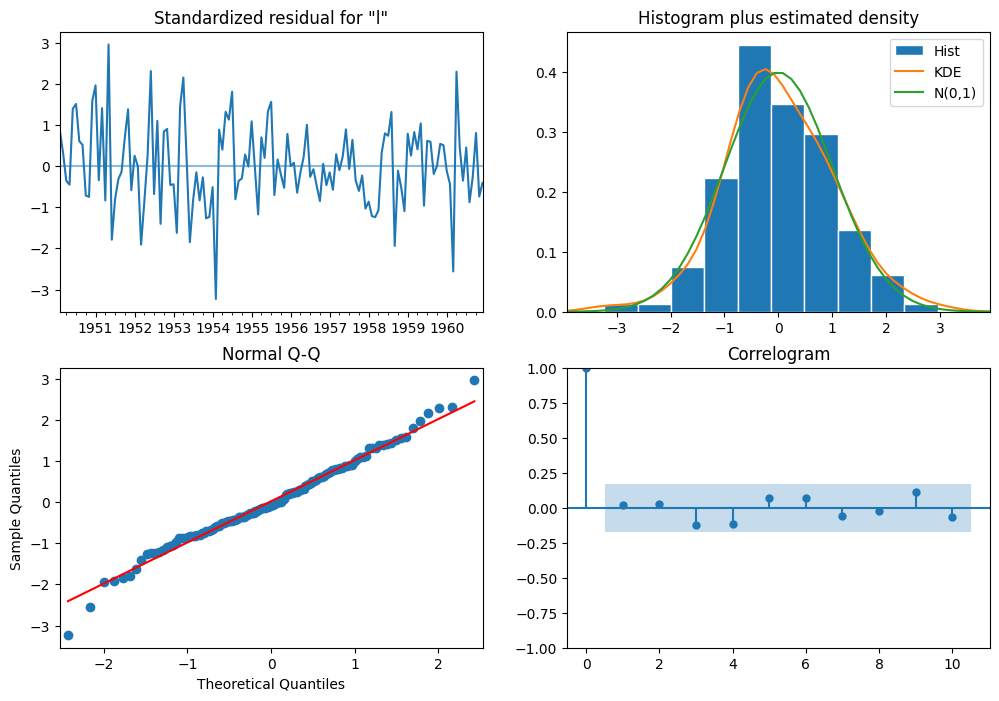

In [74]:
# Diagnostic

results_4.plot_diagnostics(figsize=(12, 8))
plt.show()

### Automated order selection

In [69]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.4 MB/s eta 0:00:00


In [75]:
import pmdarima as pm

model = pm.auto_arima(df_log, seasonal=True, m=12,
                      d=1, D=1,
                      max_p=2, max_q=2,
                      max_P=2, max_Q=2,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True
                      )

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-477.718, Time=4.98 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-434.830, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-474.813, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-483.393, Time=0.89 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-449.978, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-481.906, Time=1.00 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-481.956, Time=2.24 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-477.399, Time=0.36 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-479.901, Time=1.56 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-467.553, Time=0.34 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-481.893, Time=1.28 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-481.610, Time=1.75 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-481.484, Time=2.61 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-479.399, Time=1.94 sec
 ARIMA(0,1,1)(0,1,1

Great! The best model is the same as our previous selection.

## Prediction and Evaluation

In [94]:
best_model = SARIMAX(df_log, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))
results = best_model.fit()

# Generate predictions on the known dataset for evaluation
dynamic_prediction = results.get_prediction(start=-12, dynamic=True)

# Extract prediction mean
mean_prediction = dynamic_prediction.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_prediction.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.iloc[:,0]
upper_limits = confidence_intervals.iloc[:,1]


# go back to the original values
mean_prediction_original_scale = np.exp(mean_prediction)
lower_limits_original_scale = np.exp(lower_limits)
upper_limits_original_scale = np.exp(upper_limits)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


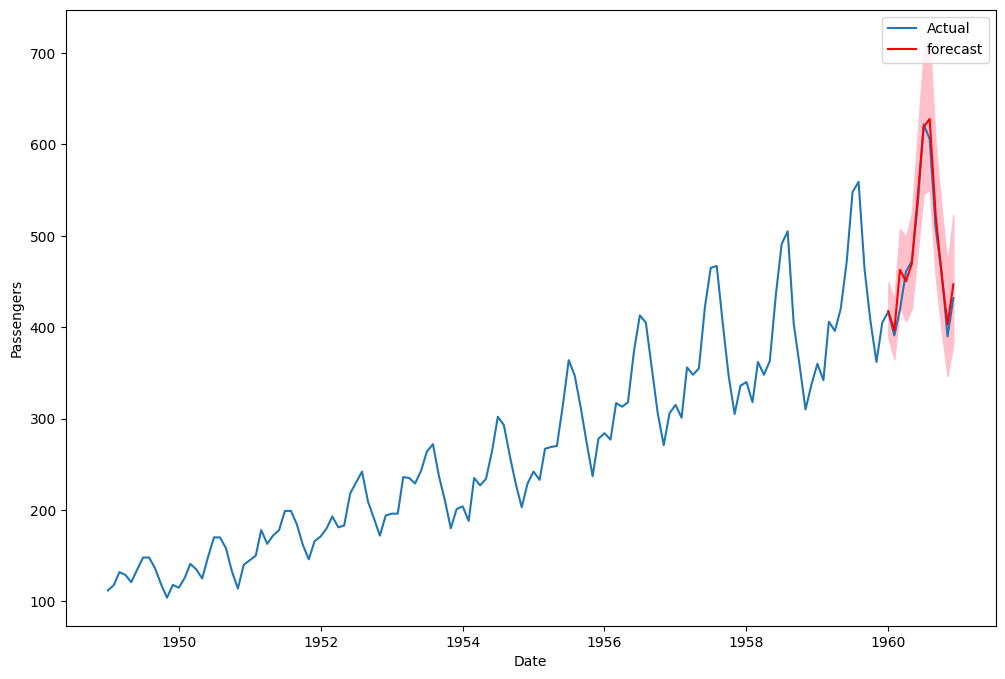

In [95]:
fig, ax = plt.subplots(figsize=(12, 8))
# plot the data
plt.plot(df.index, df['Passengers'], label='Actual')
# plot your mean forecast
plt.plot(mean_prediction.index, mean_prediction_original_scale, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits_original_scale,
         upper_limits_original_scale, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

In [97]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

actual_values = df['Passengers'][-12:]

# Compute MAE
sarima_mae = mean_absolute_error(actual_values, mean_prediction_original_scale)

# Compute MSE
sarima_mse = mean_squared_error(actual_values, mean_prediction_original_scale)

print(f'Mean Absolute Error (MAE): {sarima_mae}')
print(f'Mean Squared Error (MSE): {sarima_mse}')

# Save the fitted model to a file using joblib
# joblib.dump(results, 'best_sarima_model.joblib')

Mean Absolute Error (MAE): 11.884127218761103
Mean Squared Error (MSE): 271.73363365739266


['best_sarima_model.joblib']

## Deploy Model and Forecast

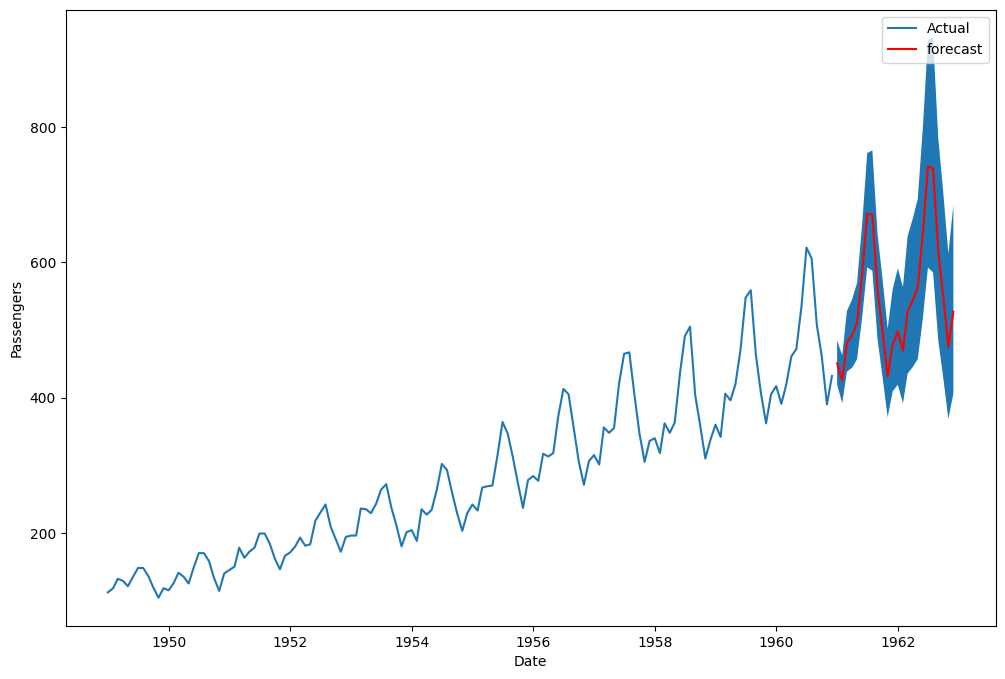

In [98]:
# Loading the model
loaded_model = joblib.load('best_sarima_model.joblib')

# Forecasting next 24 steps
forecast = loaded_model.get_forecast(steps=24)

forecast_mean = forecast.predicted_mean
forecast_mean_original_scale = np.exp(forecast_mean)


ci = forecast.conf_int()
lower_limits = ci.iloc[:,0]
upper_limits = ci.iloc[:,1]
lower_limits_original_scale = np.exp(lower_limits)
upper_limits_original_scale = np.exp(upper_limits)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df.index, df['Passengers'], label='Actual')
ax.plot(forecast_mean_original_scale.index, forecast_mean_original_scale, color='r', label='forecast')
ax.fill_between(ci.index, lower_limits_original_scale, upper_limits_original_scale)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.legend()
plt.show()